In [1]:
import brainpy as bp
import brainpy.math as bm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
import scipy

import sys
sys.path.append('..')
from cann import CANN1D

seed = 123


/home/zilong/anaconda3/envs/hippocampalsequence/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1, simulate theta sweep at two different adaptation strength

In [2]:
#set default ramndom seed for reproducibility
np.random.seed(seed)
#set backend to cpu
bm.set_platform('cpu')
#build and run the network
sweep_cann_1 = CANN1D(tau=1, tau_v=48., num=128, mbar=5.5, A=0.01)

v_ext = sweep_cann_1.a / 144 * 0.55   #animal speed
sweep_dur = 2.5*np.pi / v_ext              #duration of simulation
dt = bm.get_dt()                     #simulation time step                         
steps = int(sweep_dur / dt)                #steps of simulation

position = np.zeros(steps)
position[0] = -np.pi/3               #initial position
#generate position array
for i in range(steps)[1:]:
    position[i] = position[i - 1] + v_ext * dt
    if position[i] > np.pi:          #periodic boundary condition
        position[i] -= 2 * np.pi

position = position.reshape((-1, 1)) #reshape to (steps, 1) array to fit the input shape

noise = 0.001*np.random.randn(steps,sweep_cann_1.num) #add independent noise to the input with level 0.01

#generate series of external input bump
Iext = sweep_cann_1.get_stimulus_by_pos(position) + noise

#simulate the network
sweep_runner_1 = bp.DSRunner(sweep_cann_1,
                     inputs=('input', Iext, 'iter'),
                     monitors=['u', 'v', 'r','center','centerI'])
sweep_runner_1.run(sweep_dur)


#############################################################################################################
#set default ramndom seed for reproducibility
np.random.seed(seed)
#set backend to cpu
bm.set_platform('cpu')
#build and run the network
sweep_cann_2 = CANN1D(tau=1, tau_v=48, num=128, mbar=9.,  A=0.01)

#simulate the network
sweep_runner_2 = bp.DSRunner(sweep_cann_2,
                     inputs=('input', Iext, 'iter'),
                     monitors=['u', 'v', 'r','center','centerI'])
sweep_runner_2.run(sweep_dur)

Predict 51407 steps: : 100%|██████████| 51407/51407 [00:00<00:00, 58678.44it/s]


### 2, simulate replay at two different adaptation strength

In [3]:
dt = bm.get_dt()
replay_dur = 200         #simulate 200 ms, roughly the length of a SWR
init_dur = 50 #initial 10 ms to let the network settle

#build and run the network
#set default ramndom seed for reproducibility
np.random.seed(seed)
#set backend to cpu
bm.set_platform('cpu')

replay_cann_1 = CANN1D(tau=1., tau_v=48., num=128, mbar=1.5)
replay_cann_1.reset_state()
Iext, length = bp.inputs.section_input(
    values=[replay_cann_1.get_stimulus_by_pos(-3/4*np.pi), 0.], #initial position of the bump
    durations=[init_dur, replay_dur],
    return_length=True
)
noise = 0.02* np.random.randn(len(Iext), replay_cann_1.num) #add independent noise to the input with level 0.02
Iext = Iext + noise
Iext = bm.as_numpy(Iext)

#run the network
replay_runner_1 = bp.DSRunner(replay_cann_1,
                     inputs=('input', Iext, 'iter'),
                     monitors=['r'])

replay_runner_1.run(length)

#############################################################################################################
#set default ramndom seed for reproducibility
np.random.seed(seed)
#set backend to cpu
bm.set_platform('cpu')
#build and run the network
replay_cann_2 = CANN1D(tau=1., tau_v=48., num=128, mbar=3.5)
replay_cann_2.reset_state()
Iext, length = bp.inputs.section_input(
    values=[replay_cann_2.get_stimulus_by_pos(-3/4*np.pi), 0.], #initial position of the bump
    durations=[init_dur, replay_dur],
    return_length=True
)
noise = 0.02* np.random.randn(len(Iext), replay_cann_2.num) #add independent noise to the input with level 0.02
Iext = Iext + noise
Iext = bm.as_numpy(Iext)

#run the network
replay_runner_2 = bp.DSRunner(replay_cann_2,
                     inputs=('input', Iext, 'iter'),
                     monitors=['r'])

replay_runner_2.run(length)


Predict 2500 steps: :   0%|          | 0/2500 [00:00<?, ?it/s]

Predict 2500 steps: : 100%|██████████| 2500/2500 [00:00<00:00, 7793.80it/s]


### 2 visualize

/tmp/ipykernel_28263/3225723993.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0,0].set_xticklabels(xticklabels, fontsize=ticksize)
/tmp/ipykernel_28263/3225723993.py:176: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1,1].set_yticklabels(yticklabels, fontsize=ticksize)


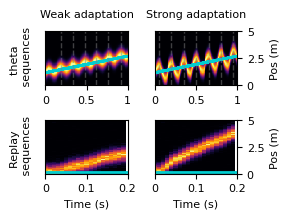

In [4]:
#make two subplots
fig, axs = plt.subplots(2, 2, figsize=(3, 2.3))
#set font size
labelsize = 8
ticksize = 8

########
#plot 1#
########

#visualize bump sweeps for 1 second. Cut the middle 1 second to avoid transient at the boundary
time = np.linspace(0, sweep_dur, steps)    #time array
time_start = int(1.9*bm.pi / v_ext/ dt)
time_end = int(2.9*bm.pi / v_ext/ dt)
time_slice=time[time_start:time_end]
#subtract time 0 from time_slice
time_slice = time_slice - time_slice[0]

pos = np.linspace(-np.pi,np.pi,sweep_cann_1.num+1)[0:-1]
fr = sweep_runner_1.mon.r.T[:,time_start:time_end]
cI = sweep_runner_1.mon.centerI[time_start:time_end]

##Theta oscillations
relative_pos = sweep_runner_1.mon.center[time_start:time_end] - sweep_runner_1.mon.centerI[time_start:time_end]
relative_pos = bm.where(relative_pos > np.pi, relative_pos - 2*np.pi,  relative_pos)
relative_pos = bm.where(relative_pos < -np.pi, relative_pos + 2*np.pi,  relative_pos)
relative_pos = np.squeeze(relative_pos)
Peaks,_ = scipy.signal.find_peaks(relative_pos, width=300)

c = axs[0,0].pcolormesh(time_slice[0:-1:100], pos, fr[:,0:-1:100]*1e3, cmap='inferno')
#add animal position to the plot
axs[0,0].plot(time_slice, cI, color='darkturquoise', linewidth=1, alpha=1.0)

#add separate lines to theta sweeps
for peaks in Peaks:
    axs[0,0].plot([time_slice[peaks], time_slice[peaks]],[-np.pi,np.pi],color='grey',linewidth=1, linestyle='--', alpha=0.5)

#set xlim and ylim
axs[0,0].set_xlim([0, 1e3])
# # set x and y ticks
xticks = np.linspace(0, 1e3, 3)
xticklabels = [0, 0.5, 1]
axs[0,0].set_xticklabels(xticklabels, fontsize=ticksize)
axs[0,0].set_xticks(xticks)
axs[0,0].tick_params(axis='x', labelsize=ticksize)

axs[0,0].set_ylim([-2.5,2.5])
axs[0,0].set_yticks([])
axs[0,0].set_ylabel('theta \n sequences', fontsize=labelsize, labelpad=10)

#add title
axs[0,0].set_title('Weak adaptation', fontsize=labelsize, pad=10)

########
#plot 2#
########

#visualize bump sweeps for 1 second. Cut the middle 1 second to avoid transient at the boundary
time = np.linspace(0, sweep_dur, steps)    #time array
time_start = int(1.9*bm.pi / v_ext/ dt)
time_end = int(2.9*bm.pi / v_ext/ dt)
time_slice=time[time_start:time_end]
#subtract time 0 from time_slice
time_slice = time_slice - time_slice[0]

pos = np.linspace(-np.pi,np.pi,sweep_cann_2.num+1)[0:-1]
fr = sweep_runner_2.mon.r.T[:,time_start:time_end]
cI = sweep_runner_2.mon.centerI[time_start:time_end]

##Theta oscillations
relative_pos = sweep_runner_2.mon.center[time_start:time_end] - sweep_runner_2.mon.centerI[time_start:time_end]
relative_pos = bm.where(relative_pos > np.pi, relative_pos - 2*np.pi,  relative_pos)
relative_pos = bm.where(relative_pos < -np.pi, relative_pos + 2*np.pi,  relative_pos)
relative_pos = np.squeeze(relative_pos)
Peaks,_ = scipy.signal.find_peaks(relative_pos, width=300)

c = axs[0,1].pcolormesh(time_slice[0:-1:100], pos, fr[:,0:-1:100]*1e3, cmap='inferno')
#add animal position to the plot
axs[0,1].plot(time_slice, cI, color='darkturquoise', linewidth=1, alpha=1.0)

#add separate lines to theta sweeps
for peaks in Peaks:
    axs[0,1].plot([time_slice[peaks], time_slice[peaks]],[-np.pi,np.pi],color='grey',linewidth=1, linestyle='--', alpha=0.5)

#set xlim and ylim
axs[0,1].set_xlim([0, 1e3])
axs[0,1].set_ylim([-2.5,2.5])
#set x and y labels
#set x and y labels
axs[0,1].set_ylabel('Pos (m)', fontsize=labelsize)
axs[0,1].yaxis.set_label_position("right")
axs[0,1].yaxis.tick_right()
    
# set x and y ticks
xticks = np.linspace(0, 1e3, 3)
yticks = np.linspace(-2.5,2.5,3)
#set tick labels
xticklabels = [0, 0.5, 1]
yticklabels = [0, 2.5, 5]

axs[0,1].set_xticks(xticks)
axs[0,1].set_yticks(yticks)
axs[0,1].set_xticklabels(xticklabels, fontsize=ticksize)
axs[0,1].set_yticklabels(yticklabels, fontsize=ticksize)

axs[0,1].tick_params(axis='x', labelsize=ticksize)
axs[0,1].tick_params(axis='y', labelsize=ticksize)

#add title 
axs[0,1].set_title('Strong adaptation', fontsize=labelsize, pad=10)

########
#plot 3#
########

fr = replay_runner_1.mon.r.T
pos = np.linspace(-np.pi,np.pi,replay_cann_1.num)
replay_steps = int(replay_dur / dt)
time = np.linspace(init_dur, replay_dur+init_dur, replay_steps)
init_index = int(init_dur/dt)
c = axs[1,0].pcolormesh(time[::100]-time[0], pos, fr[:,init_index:-1:100]*1e3, cmap='inferno')
axs[1,0].set_xlim((0,200))

#add an horizontal line to indicate the position of the bump at y=-3/4*np.pi
axs[1,0].plot([0,200],[-3/4*np.pi,-3/4*np.pi],color='darkturquoise',linewidth=2, alpha=1)

#set xlim and ylim
axs[1,0].set_xlim([0, 200])
axs[1,0].set_ylim([-2.5,2.5])
#set x and y labels
axs[1,0].set_xlabel('Time (s)', fontsize=labelsize)
axs[1,0].set_ylabel('Replay \n sequences', fontsize=labelsize, labelpad=10)

# set x and y ticks
xticks = np.linspace(0, 200, 3)
#set tick labels
xticklabels = [0, 0.1, 0.2]
axs[1,0].set_xticks(xticks)
axs[1,0].set_xticklabels(xticklabels, fontsize=ticksize)

axs[1,0].tick_params(axis='x', labelsize=ticksize)

#yticks off
axs[1,0].set_yticks([])

########
#plot 4#
########

fr = replay_runner_2.mon.r.T
pos = np.linspace(-np.pi,np.pi,replay_cann_2.num)
replay_steps = int(replay_dur / dt)
time = np.linspace(init_dur, replay_dur+init_dur, replay_steps)
init_index = int(init_dur/dt)

c = axs[1,1].pcolormesh(time[::100]-time[0], pos, fr[:,init_index:-1:100]*1e3, cmap='inferno')
axs[1,1].set_xlim((0,200))
   
#add an horizontal line to indicate the position of the bump at y=-3/4*np.pi 
axs[1,1].plot([0,200],[-3/4*np.pi,-3/4*np.pi],color='darkturquoise',linewidth=2, alpha=1)
    
#set xlim and ylim
axs[1,1].set_xlim([0, 200])
axs[1,1].set_ylim([-2.5,2.5])
axs[1,1].set_xlabel('Time (s)', fontsize=labelsize)
axs[1,1].set_ylabel('Pos (m)', fontsize=labelsize)
axs[1,1].yaxis.set_label_position("right")
axs[1,1].yaxis.tick_right()
   
# set x and y ticks
yticks = np.linspace(-2.5,2.5,3)
yticklabels = [0, 2.5, 5]
xticklabels = [0, 0.1, 0.2]
axs[1,1].set_xticks(xticks)
axs[1,1].set_xticklabels(xticklabels, fontsize=ticksize)
axs[1,1].set_yticklabels(yticklabels, fontsize=ticksize)

axs[1,1].tick_params(axis='x', labelsize=ticksize)
axs[1,1].tick_params(axis='y', labelsize=ticksize)


plt.tight_layout()

#save
plt.savefig('./Fig_model_sweep_replay.pdf', bbox_inches='tight', dpi=300)


/tmp/ipykernel_28263/284293933.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_user)


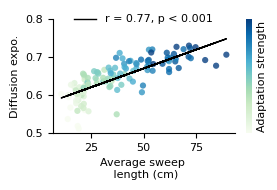

In [14]:
# ax 3
fig, ax = plt.subplots(1, 1, figsize=(3, 2)) 

labelsize = 8
ticksize = 8


# load the data from the pickle file
import pickle

with open(
    "/home/zilong/Desktop/AdaptiveAttractorForSequences/PaperFigureCode/sweep_replay_correlation.pkl",
    "rb",
) as f:
    M, MeanSweep, MeanSweepAmp, DiffusionExp = pickle.load(f)
cmap_user = "GnBu"
# Create a colormap scalar map
norm = Normalize(vmin=np.min(M), vmax=np.max(M))
cmap = cm.get_cmap(cmap_user)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # An empty array to create the color mapping

simulation_nums = DiffusionExp.shape[0]
for i in range(simulation_nums):
    ax.scatter(
        MeanSweepAmp[i, :],
        DiffusionExp[i, :],
        c=M,
        cmap=cmap_user,
        s=20,
        alpha=0.8,
        edgecolors="none",
    )
# add linear fit line to the plot using numpy.polyfit
# convert MeanSweep and DiffusionExp from 2D array to 1D array
exp_np = DiffusionExp.flatten()
sweep_len_np = MeanSweepAmp.flatten()
slope, intercept = np.polyfit(sweep_len_np, exp_np, 1)
# pearson test
corr, p = pearsonr(sweep_len_np, exp_np)
if p < 0.001:
    ax.plot(
        sweep_len_np,
        sweep_len_np * slope + intercept,
        "k-",
        label="r = %.2f, p < 0.001" % (corr),
        linewidth=1,
    )
else:
    ax.plot(
        sweep_len_np,
        sweep_len_np * slope + intercept,
        "k-",
        label="r = %.2f, p = %.3f" % (corr, p),
        linewidth=1,
    )

# legend
ax.legend(fontsize=ticksize, frameon=False, loc="center", bbox_to_anchor=(0.5, 1.0))

# Add a colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Adaptation strength", fontsize=ticksize)
# set colorbar box off
cbar.outline.set_visible(False)
# set colorbar ticks with fontsize ticksizes
cbar.ax.tick_params(labelsize=ticksize)
#set cbar ticks off
cbar.set_ticks([])

ax.set_xlabel("Average sweep \n length (cm)", fontsize=labelsize)
ax.set_ylabel("Diffusion expo.", fontsize=labelsize)
# change the xticks from meter to centermeter by times 100
ax.set_xticks([0.25, 0.5, 0.75])
ax.set_xticklabels([25, 50, 75])
# set y ticks
ax.set_yticks([0.5, 0.6, 0.7, 0.8])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
#tick size
ax.tick_params(axis="x", labelsize=ticksize)
ax.tick_params(axis="y", labelsize=ticksize)

plt.tight_layout()
#save
plt.savefig('./Fig_model_sweep_replay_correlation.pdf', bbox_inches='tight', dpi=300)